# Kütüphanelerin import edilmesi

In [1]:
import numpy as np
import pandas as pd
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2


from tqdm.notebook import tqdm_notebook as tqdm

import os

In [2]:
print(os.listdir("./input"))

['.DS_Store', 'real_and_fake_face_detection']


In [3]:
real = "./input/real_and_fake_face_detection/real_and_fake_face/training_real/"
fake = "./input/real_and_fake_face_detection/real_and_fake_face/training_fake/"

real_path = os.listdir(real)
fake_path = os.listdir(fake)

# Gerçek ve sahte yüzleri görselleştirme

In [4]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

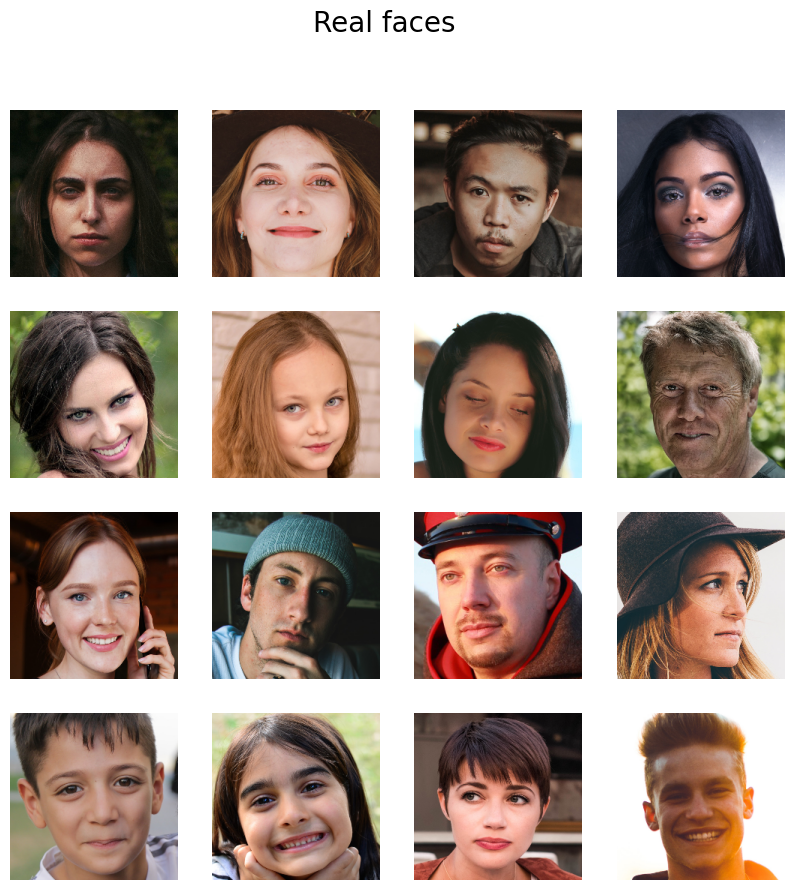

In [5]:
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(real + real_path[i]), cmap='gray')
    plt.suptitle("Real faces",fontsize=20)
    plt.axis('off')

plt.show()

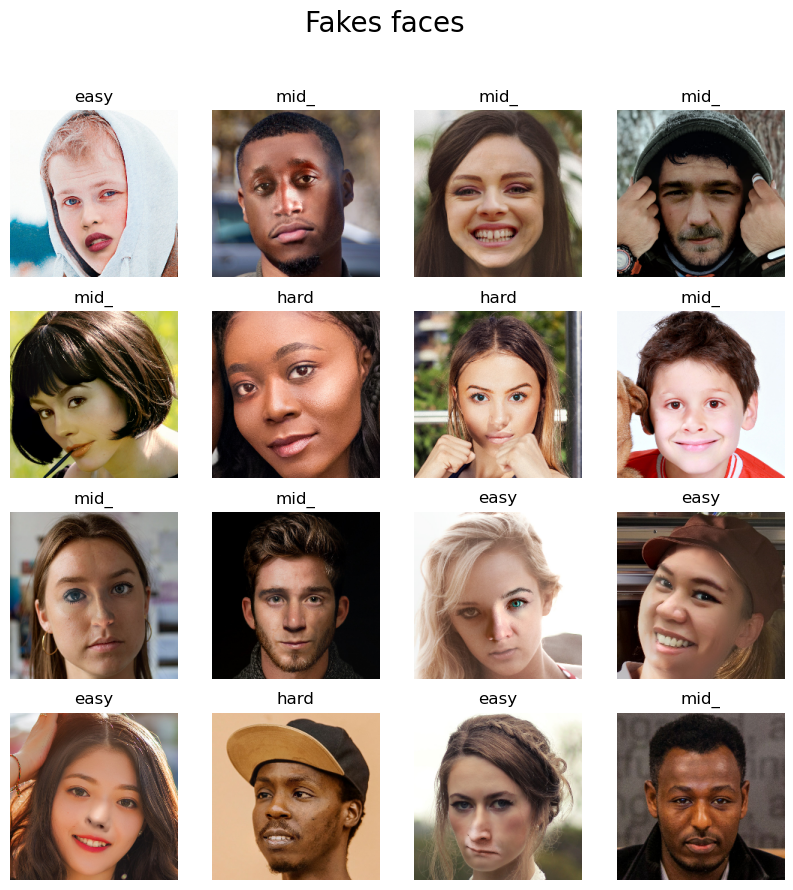

In [6]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(fake + fake_path[i]), cmap='gray')
    plt.suptitle("Fakes faces",fontsize=20)
    plt.title(fake_path[i][:4])
    plt.axis('off')

plt.show()

In [7]:
dataset_path = "/Users/osmantunahanincirkus/Desktop/fakeFaceDec"

# Veri artırma

In [8]:
data_with_aug = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1./255,
                                  validation_split=0.2)

In [9]:
train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="training")

Found 1633 images belonging to 2 classes.


In [10]:
val = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="validation"
                                          )

Found 408 images belonging to 2 classes.


# Cnn Modelimiz

In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 64)       0

In [13]:
tf.keras.backend.clear_session()

model = Sequential([mnet,
                    GlobalAveragePooling2D(),
                    Dense(512, activation = "relu"),
                    BatchNormalization(),
                    Dropout(0.3),
                    Dense(128, activation = "relu"),
                    Dropout(0.1),
                    # Dense(32, activation = "relu"),
                    # Dropout(0.3),
                    Dense(2, activation = "softmax")])



model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")



# Yeniden Çağırma (callbacks)

In [14]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001 
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [15]:
hist = model.fit(train,
                 epochs=20,
                 callbacks=[lr_callbacks],
                 validation_data=val)


Epoch 1/20


2023-06-06 05:42:03.686775: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


52/52 [==============================] - 15s 261ms/step - loss: 0.1806 - accuracy: 0.9284 - val_loss: 0.0075 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/20
52/52 [==============================] - 14s 263ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 3.9925e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/20
52/52 [==============================] - 14s 264ms/step - loss: 4.7672e-04 - accuracy: 1.0000 - val_loss: 1.1745e-04 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/20
52/52 [==============================] - 14s 269ms/step - loss: 4.6334e-04 - accuracy: 1.0000 - val_loss: 7.9643e-05 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 5/20
52/52 [==============================] - 14s 276ms/step - loss: 4.2041e-04 - accuracy: 1.0000 - val_loss: 4.5629e-05 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 6/20
52/52 [==============================] - 15s 290ms/step - loss: 3.9489e-04 - accuracy: 1.0000 - val_loss: 5.1720e-05 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 7/20
52/52 [=========

# Doğruluğu (accuracy ) ve Kaybı Görselleştirme

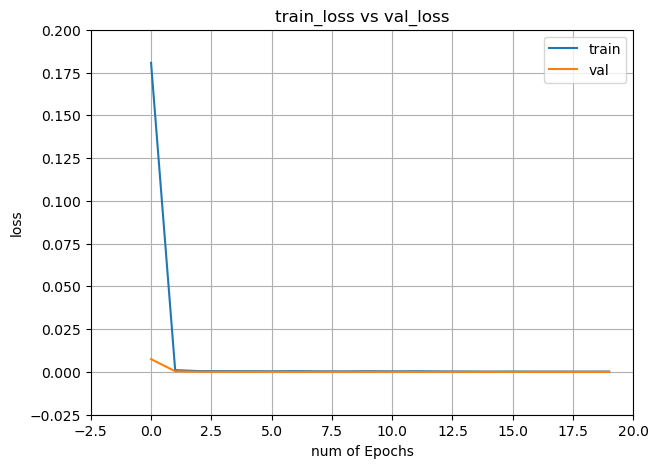

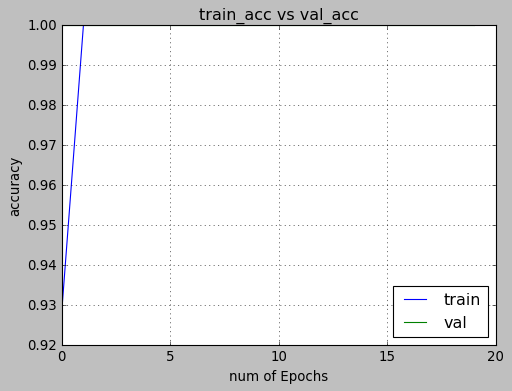

In [16]:
epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

# Cnn Modelini Deneme

In [17]:
train = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=98,
                                          subset="training")

val = data_with_aug.flow_from_directory(dataset_path,
                                          class_mode="binary",
                                          target_size=(224, 224),
                                          batch_size=98,
                                          subset="validation"
                                          )

Found 1633 images belonging to 2 classes.
Found 408 images belonging to 2 classes.


In [18]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)      

In [20]:
# model = Sequential()
# for layer in vgg16_model.layers[:-1]:
#     model.add(layer)

# for layer in model.layers:
#     layer.trainable = False
    
# model.add(Dense(2, activation='softmax'))


model = Sequential([vgg16_model,
                    Flatten(),
#                     GlobalAveragePooling2D(),
#                     Dense(512, activation = "relu"),
#                     BatchNormalization(),
#                     Dropout(0.3),
#                     Dense(128, activation = "relu"),
#                     Dropout(0.1),
#                     # Dense(32, activation = "relu"),
#                     # Dropout(0.3),
                    Dense(2, activation = "softmax")])



model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics="accuracy")



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_5 (Dense)             (None, 2)                 50178     
                                                                 
Total params: 14,764,866
Trainable params: 50,178
Non-trainable params: 14,714,688
_________________________________________________________________


In [21]:
hist = model.fit(train, 
                 epochs=20, 
                 callbacks=[lr_callbacks], 
                 validation_data=val)


Epoch 1/20
17/17 [==============================] - 219s 13s/step - loss: 0.0389 - accuracy: 0.9761 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 2/20
17/17 [==============================] - 240s 14s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/20
17/17 [==============================] - 246s 15s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 4/20
17/17 [==============================] - 245s 15s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 5/20
17/17 [==============================] - 245s 15s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 6/20
17/17 [==============================] - 252s 15s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 7/20
17/

# Doğruluğu (accuracy ) ve Kaybı Görselleştirme

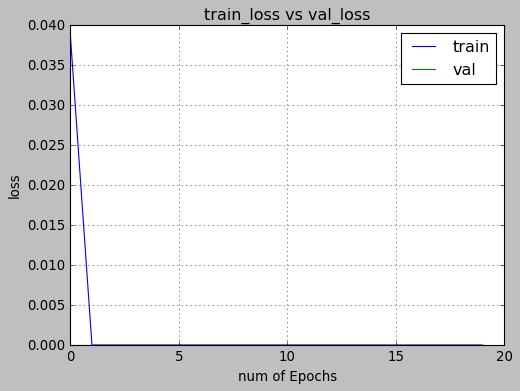

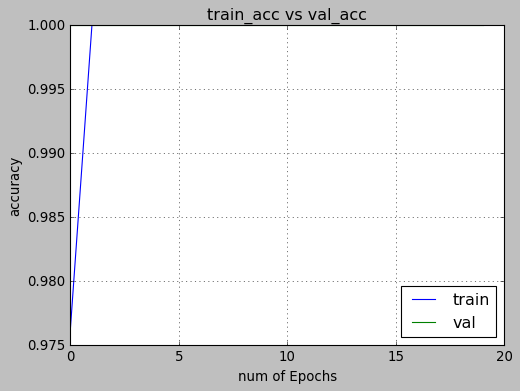

In [22]:
epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

# Tahminler

In [24]:
#Test resimlerinin tahmini için array oluşturma

predictions = model.predict(val)

5/5 [==============================] - 39s 7s/step


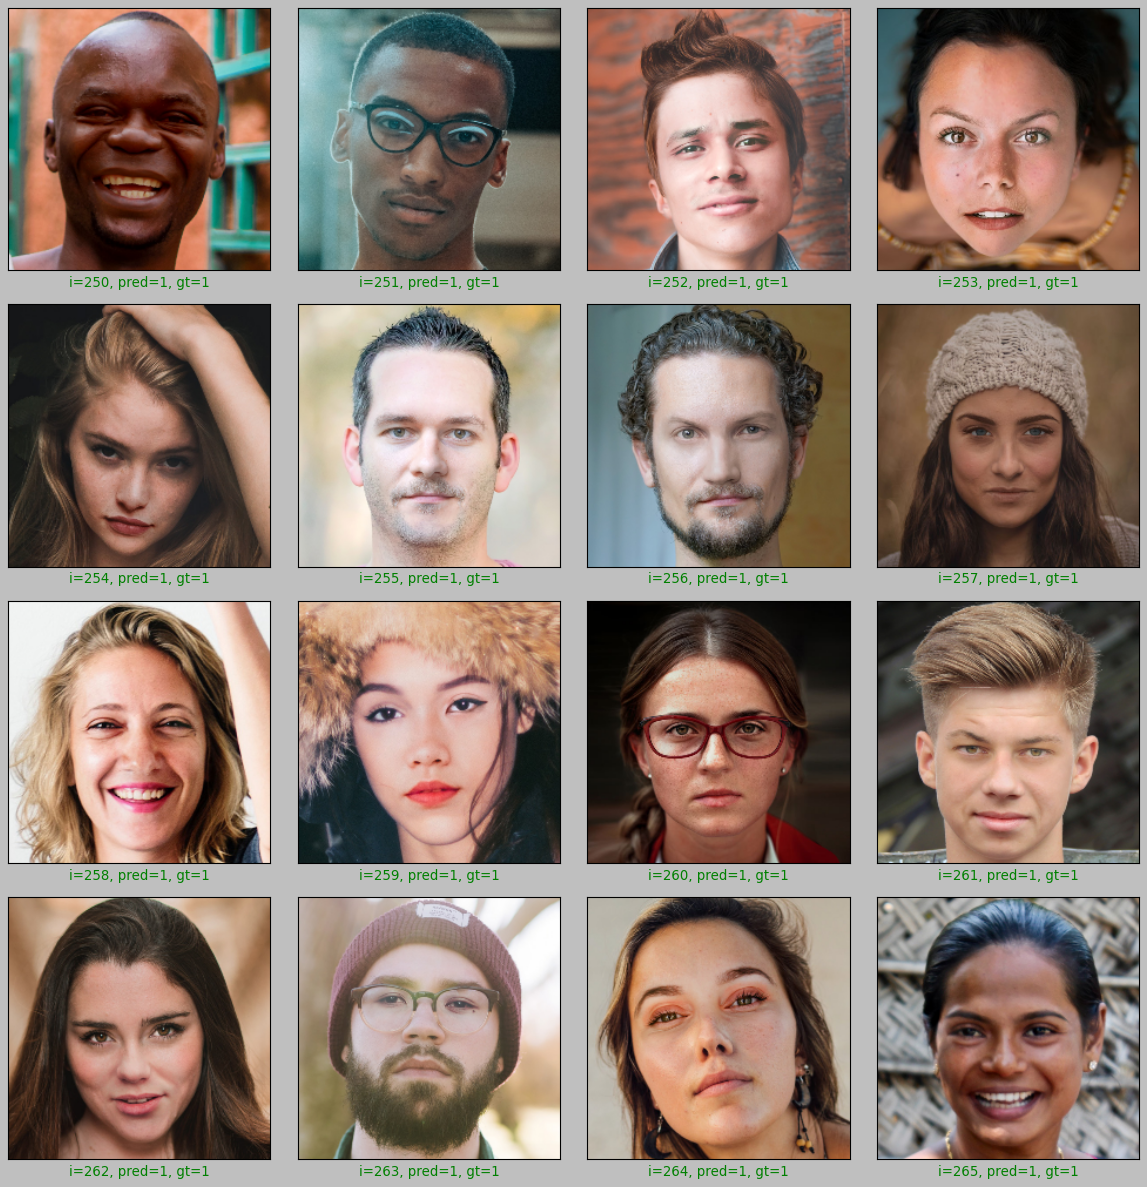

In [29]:
val_path = "./"

plt.figure(figsize=(15,15))

start_index = 250

for i in range(16):
  plt.subplot(4,4, i+1)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  preds = np.argmax(predictions[[start_index+i]])
    
  gt = val.filenames[start_index+i][9:13]

  
  if gt == "fake":
    gt = 0
  else:
    gt = 1
    
  if preds != gt:
    col ="r"
  else:
    col = "g"

  plt.xlabel('i={}, pred={}, gt={}'.format(start_index+i,preds,gt),color=col)
  plt.imshow(load_img(val_path+val.filenames[start_index+i]))
  plt.tight_layout()

plt.show()